In [ ]:
#Collap Drive Bağlama
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import joblib

## Verilerin Çekilmesi Ve Ön İşleme

In [ ]:
#Train ve Test Veri Setleri Kurulumu

path = "/content/drive/MyDrive/Binovist  Sentiment Analysis/data/Hepsiburada Dataset 492k(%10 test)/"

df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")

dataframes = {'df_train': df_train, 'df_test': df_test}

yes_responses = {'evet', 'yes', 'y', '1', 'tamam', 'onay', 'olur', 'e'}
no_responses = {'hayır', 'no', 'n', '0', 'hayir', 'olmaz', 'h'}

In [ ]:
print(df_train.head())
print(len(df_train))

                                                text     label         dataset
0  ürünü hepsiburadadan alalı 3 hafta oldu. orjin...  Positive  urun_yorumlari
1  ürünlerden çok memnunum, kesinlikle herkese ta...  Positive  urun_yorumlari
2      hızlı kargo, temiz alışveriş.teşekkür ederim.  Positive  urun_yorumlari
3               Çünkü aranan tapınak bu bölgededir .      Notr            wiki
4  bu telefonu başlıca alma nedenlerim ise elimde...  Positive  urun_yorumlari
440679


In [ ]:
print(df_test.head())
print(len(df_test))

                                                text     label         dataset
0      Kral akbaba dikkat çekici renklere sahiptir .      Notr            wiki
1   ısrarla korkutmayı başarıyor. sanki korku çok...  Positive           HUMIR
2  Neşe ve Üzüntü köprünün kırılmaya başlamasıyla...      Notr            wiki
3  i phone 5 ten sonra gene 4'' ekranı tercih ett...  Positive  urun_yorumlari
4    Beşinci sezonda diziye yeni oyuncular katıldı .      Notr            wiki
48965


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440679 entries, 0 to 440678
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     440679 non-null  object
 1   label    440679 non-null  object
 2   dataset  440679 non-null  object
dtypes: object(3)
memory usage: 10.1+ MB


In [ ]:
print(df_test.isnull().sum())
print("-"*20)
print(df_train.isnull().sum())

text       0
label      0
dataset    0
dtype: int64
--------------------
text       0
label      0
dataset    0
dtype: int64


In [ ]:
df_train.describe()

,text,label,dataset
count,440679,440679,440679
unique,440058,3,6
top,Memnun kaldık.,Positive,urun_yorumlari
freq,17,235949,210693


In [ ]:
df_train['dataset'].value_counts()

,count
dataset,
urun_yorumlari,210693
wiki,153364
HUMIR,58575
tweet-pn,9959
magaza_yorumlari,7627
random,461


In [ ]:
df_train['label'].value_counts()

,count
label,
Positive,235949
Notr,153825
Negative,50905


In [ ]:
for name, df in dataframes.items():
  label_distribution = df.groupby('dataset')['label'].value_counts().unstack().fillna(0)
  print(name[3:] + " Labels for Negatif Positive")
  print(label_distribution)
  print("-"*len("label             Negative      Notr  Positive"))

train Labels for Negatif Positive
label             Negative      Notr  Positive
dataset                                       
HUMIR              29265.0       0.0   29310.0
magaza_yorumlari    3810.0       0.0    3817.0
random                 0.0     461.0       0.0
tweet-pn            4456.0       0.0    5503.0
urun_yorumlari     13374.0       0.0  197319.0
wiki                   0.0  153364.0       0.0
----------------------------------------------
test Labels for Negatif Positive
label             Negative     Notr  Positive
dataset                                      
HUMIR               3235.0      0.0    3190.0
magaza_yorumlari     427.0      0.0     435.0
random                 0.0     43.0       0.0
tweet-pn             512.0      0.0     584.0
urun_yorumlari      1482.0      0.0   22008.0
wiki                   0.0  17049.0       0.0
----------------------------------------------


Positive Negative ve Nötr Değerlerinin Sayısal Gösterimi

In [ ]:
# Label'ları sayısal değerlere dönüştürmek için
label_mapping = {'Positive': 2, 'Notr': 1, 'Negative': 0}
for name, df in dataframes.items():
  df['label_numeric'] = df['label'].map(label_mapping)
  print(name + " Hatasız Eklendi")

df_train Hatasız Eklendi
df_test Hatasız Eklendi


In [ ]:
df_train.head()

,text,label,dataset,label_numeric
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,Positive,urun_yorumlari,2
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",Positive,urun_yorumlari,2
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",Positive,urun_yorumlari,2
3,Çünkü aranan tapınak bu bölgededir .,Notr,wiki,1
4,bu telefonu başlıca alma nedenlerim ise elimde...,Positive,urun_yorumlari,2


In [ ]:
df_test.head()

,text,label,dataset,label_numeric
0,Kral akbaba dikkat çekici renklere sahiptir .,Notr,wiki,1
1,ısrarla korkutmayı başarıyor. sanki korku çok...,Positive,HUMIR,2
2,Neşe ve Üzüntü köprünün kırılmaya başlamasıyla...,Notr,wiki,1
3,i phone 5 ten sonra gene 4'' ekranı tercih ett...,Positive,urun_yorumlari,2
4,Beşinci sezonda diziye yeni oyuncular katıldı .,Notr,wiki,1


## Kopya Spam Yorum Tespiti

In [ ]:
print("*"*len("                                                  text  count  text_length"))
for name, df in dataframes.items():
  print(f"\nProcessing {name}...")

  duplicate_comments = df[df.duplicated(subset=['text'], keep=False)]

  duplicate_counts = duplicate_comments['text'].value_counts()

  duplicates_df = pd.DataFrame({'text': duplicate_counts.index, 'count': duplicate_counts.values})

  duplicates_df['text_length'] = duplicates_df['text'].apply(len)

  duplicates_df = duplicates_df.sort_values(by='count', ascending=False)

  print("\nDuplicate comments sorted by frequency:")
  print(duplicates_df)

  # Kopya yorumları ve tekrar sayılarını CSV dosyasına kaydet
  duplicates_df.to_csv(path + name +"_DuplicatedControl.csv", index=False)

  print("-"*len(name +"_DuplicatedControl.csv Kaydedildi"))
  print(name +"_DuplicatedControl.csv Kaydedildi")
  print("-"*len(name +"_DuplicatedControl.csv Kaydedildi"))

  # Metin uzunluklarının ortalamasını ve modunu hesapla
  mean_length = duplicates_df['text_length'].mean()
  mode_length = duplicates_df['text_length'].mode()[0]

  # Duplicate count ortalaması ve modu
  mean_dupfrequency_length = duplicates_df['count'].mean()
  mode_dupfrequency_length = duplicates_df['count'].mode()[0]

  # Duplicate Sıklığı ortalması ve modu
  print("\nMean Duplicate Frequency length:", mean_dupfrequency_length)
  print("Mode Duplicate Frequency length:", mode_dupfrequency_length)

  # Sonuçları yazdır
  print("\nMean text length:", mean_length)
  print("Mode text length:", mode_length)
  print("*"*len("                                                  text  count  text_length"))

**************************************************************************

Processing df_train...

Duplicate comments sorted by frequency:
                                                  text  count  text_length
0                                       Memnun kaldık.     17           14
1                                   Cok memnun kaldık.     11           18
2                                      Çok kullanışlı.      9           15
3                                           Harikaydı.      8           10
4                                             Güzeldi.      7            8
..                                                 ...    ...          ...
196  acentemikaturun bu sitede yazmis oldugu tum ol...      2          352
195                            ürünü henüz kullanmadım      2           23
194                                        gayet güzel      2           11
193   Evet belki gelmiş geçmiş en iyi İKİNCİ filmi ...      2          205
482  harikabana bu oteli işyerinden

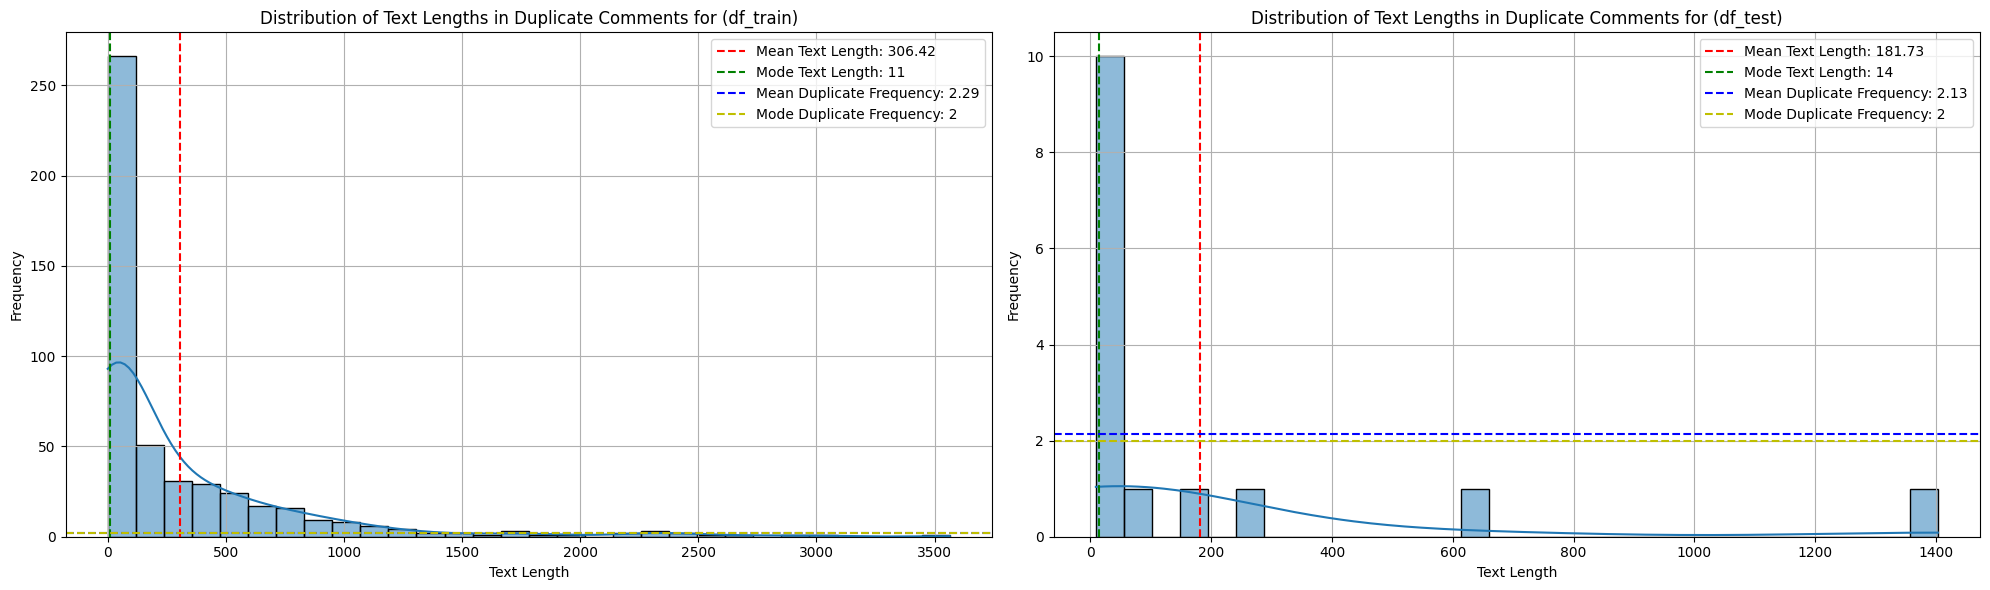

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, (name, df) in enumerate(dataframes.items()):
    duplicates_df = pd.read_csv(path + name + "_DuplicatedControl.csv")

    # Metin uzunluklarının ortalamasını ve modunu hesapla
    mean_length = duplicates_df['text_length'].mean()
    mode_length = duplicates_df['text_length'].mode()[0]

    # Duplicate count ortalaması ve modu
    mean_dupfrequency_length = duplicates_df['count'].mean()
    mode_dupfrequency_length = duplicates_df['count'].mode()[0]

    # Histogram grafiği oluşturma
    sns.histplot(duplicates_df['text_length'], bins=30, kde=True, ax=axes[i])
    axes[i].axvline(mean_length, color='r', linestyle='--', label=f'Mean Text Length: {mean_length:.2f}')
    axes[i].axvline(mode_length, color='g', linestyle='--', label=f'Mode Text Length: {mode_length}')
    axes[i].axhline(mean_dupfrequency_length, color='b', linestyle='--', label=f'Mean Duplicate Frequency: {mean_dupfrequency_length:.2f}')
    axes[i].axhline(mode_dupfrequency_length, color='y', linestyle='--', label=f'Mode Duplicate Frequency: {mode_dupfrequency_length}')
    axes[i].set_title(f'Distribution of Text Lengths in Duplicate Comments for ({name})')
    axes[i].set_xlabel('Text Length')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

For Döngüsü

In [ ]:
for name, df in dataframes.items():
  break
  #print(name, df)

for df in dataframes:
  break
  #print(df)

#print(f"\nProcessing {name}...")

#print(dataframes)

## Kopya Yorumların Silinmesi

In [ ]:
for name, df in dataframes.items():
  print(f"\nProcessing {name}...")
  duplicates_df = pd.read_csv(path + name + "_DuplicatedControl.csv")

  # Metin uzunluklarının ortalamasını ve modunu hesapla
  mean_length = duplicates_df['text_length'].mean()
  mode_length = duplicates_df['text_length'].mode()[0]

  # Duplicate count ortalaması ve modu
  mean_dupfrequency_length = duplicates_df['count'].mean()
  mode_dupfrequency_length = duplicates_df['count'].mode()[0]

  # Uzun ve yüksek sayıda tekrar eden metinleri bulma
  long_and_high_freq_texts = duplicates_df[(duplicates_df['text_length'] > mean_length) & (duplicates_df['count'] > mean_dupfrequency_length)]

  if long_and_high_freq_texts.empty:
    print("Çıkarılacak cümle bulunmamaktadır.")

    filtered_df = df

  else:
      # Sonuçları yazdırma
      print("Long and High Frequency Texts:")
      print(long_and_high_freq_texts[['text', 'count']])
      print("Cümle sayısı: " + str(len(long_and_high_freq_texts)))
      print("Çıkarılacak Toplam Cümle Sayısı: " + str(long_and_high_freq_texts['count'].sum()))

      # Kullanıcı girdisi
      while True:
          user_input = input("Bu cümleleri veri setinden çıkarmak ister misiniz? (Evet/Hayır): ").strip().lower()
          if user_input in yes_responses:
              # Uzun ve yüksek frekanslı metinleri ana veri setinden çıkarma
              print("Çıkarılmadan Önceki Veri Sayısı " + str(len(df)))

              filtered_df = df[~df['text'].apply(lambda x: any(phrase in x for phrase in long_and_high_freq_texts['text']))]

              print("Çıkarılmadan Önceki Veri Sayısı " + str(len(filtered_df)) + " Fark: " + str(len(df) - len(filtered_df)))


              break
          elif user_input in no_responses:
              print("Cümleler çıkarılmadı.")
              filtered_df = df
              break
          else:
              print("Geçersiz giriş. Lütfen 'Evet' veya 'Hayır' olarak cevaplayın.")

  # Filtrelenmiş veri setini CSV dosyasına kaydetme
  filtered_csv_path = path + name + "_filtered.csv"
  filtered_df.to_csv(filtered_csv_path, index=False)
  print(f"Filtered dataset saved to {filtered_csv_path}\n")



Processing df_train...
Long and High Frequency Texts:
                                                 text  count
6    Arkadaşlar 'imdb.com' sitesinde Hababam Sınıf...      7
20   Daha önce yaşamın değerini anlatan filmler iz...      4
24  önce tatil ne olduğunu öğrensinler sonra gelsi...      3
27  berbat yorgunluk tan baska bi sey olusmadimerh...      3
30  rezaletokul gezisi olarak arkadailarla gittik ...      3
35  superdısuper bır otel aılemle yaptıgım nadır g...      3
36  iğrençtibu oteli arkadaşlarımızın ortak organi...      3
38   bu film için yapacak pek fazla yorum bulamıyo...      3
42  otel berbatsu anda öteldeyim bu otel kon olara...      3
55  rezaletben antalyada o kadar hotellerde kaldim...      3
Cümle sayısı: 10
Çıkarılacak Toplam Cümle Sayısı: 35
Bu cümleleri veri setinden çıkarmak ister misiniz? (Evet/Hayır): e
Çıkarılmadan Önceki Veri Sayısı 440679
Çıkarılmadan Önceki Veri Sayısı 440644 Fark: 35
Filtered dataset saved to /content/drive/MyDrive/Binovist  Sentimen

In [ ]:
df_train_filtered = pd.read_csv(path + "df_train_filtered.csv")
df_test_filtered = pd.read_csv(path + "df_test_filtered.csv")

dataframes_filtered = {'df_train': df_train_filtered, 'df_test': df_test_filtered}

print(df_train_filtered.describe())
print(df_test_filtered.describe())

       label_numeric
count  440644.000000
mean        1.419965
std         0.688868
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
       label_numeric
count   48965.000000
mean        1.419912
std         0.688925
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000


In [ ]:
for name, df in dataframes_filtered.items():
  print(df.isnull().sum())
  print("-"*20)

text             0
label            0
dataset          0
label_numeric    0
dtype: int64
--------------------
text             0
label            0
dataset          0
label_numeric    0
dtype: int64
--------------------


## Verilerin Eşit Dağıtılması

In [ ]:
# Olumlu Olumsuz Veri Setlerinin Dengesi + Nötr Veriler eklenecek mi Kontrol Edilmesi

# Her sınıftan kaç tane örnek alınacağı (en küçük sınıfın sayısı kadar)
n_samples = df_train_filtered['label'].value_counts().min()
print("En küçük sınıfın sayısı: " + str(n_samples))

# Her sınıftan rastgele n_samples kadar örnek al
df_train_filtered = df_train_filtered.groupby('label').apply(lambda x: x.sample(n=n_samples, random_state=42)).reset_index(drop=True)

print(df_train_filtered['label'].value_counts())

# Yeni dengeli veri setini csv kaydet (isteğe bağlı)
filtered_csv_path = path + "df_train_filtered.csv"
df_train_filtered.to_csv(filtered_csv_path, index=False)
print(f"Filtered dataset saved to {filtered_csv_path}\n")


df_train_filtered = pd.read_csv(path + "df_train_filtered.csv")
df_test_filtered = pd.read_csv(path + "df_test_filtered.csv")

dataframes_filtered = {'df_train': df_train_filtered, 'df_test': df_test_filtered}

En küçük sınıfın sayısı: 50882
label
Negative    50882
Notr        50882
Positive    50882
Name: count, dtype: int64
Filtered dataset saved to /content/drive/MyDrive/Binovist  Sentiment Analysis/data/Hepsiburada Dataset 492k(%10 test)/df_train_filtered.csv



In [ ]:
for name, df in dataframes_filtered.items():
  print(df.describe())

       label_numeric
count  152646.000000
mean        1.000000
std         0.816499
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
       label_numeric
count   48965.000000
mean        1.419912
std         0.688925
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000


In [ ]:
for name, df in dataframes_filtered.items():
  print(df.isnull().sum())
  print("-"*20)

text             0
label            0
dataset          0
label_numeric    0
dtype: int64
--------------------
text             0
label            0
dataset          0
label_numeric    0
dtype: int64
--------------------


## Veri Düzenlenme Aşaması

In [ ]:
# Gerekli nltk paketlerini indir
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Ön İşleme Fonksiyonu
def pre_processing(text):
    text = text.lower()  # Büyük harften Küçük harfe çevirme
    text = re.sub("[^abcçdefgğhıijklmnoöprsştuüvyz ]", "", text)  # Harf içermeyen her türlü öğeyi silme işlemi
    text = word_tokenize(text)  # Cümledeki kelimeleri birbirinden ayırır
    text = [word for word in text if not word in stop_words]  # Stop wordler'i (Türkçe Dolgu Sözcükleri) Silme işlemi
    lemma = WordNetLemmatizer()  # Kelimenin köküne ulaşma aşaması
    text = [lemma.lemmatize(word) for word in text]  # Kelimeleri köklerine indirgeme
    text = " ".join(text)
    return text

# Ekstra stopwords ekleme
stop_words = stopwords.words("turkish")
stop_words.extend(["bir","film","filmi","filme","filmde","filmden","filmin","kadar","bi","ben"])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
for name, df in dataframes_filtered.items():
  print(f"\nProcessing {name}...")
  # Ön İşleme Fonksiyonunu Uygulama
  df['processed_text'] = df['text'].apply(pre_processing)
  print(df.head())

  # Yeni dengeli veri setini kaydet (isteğe bağlı)
  filtered_csv_path = path + name + "_filtered.csv"
  df.to_csv(filtered_csv_path, index=False)
  print(f"Filtered dataset saved to {filtered_csv_path}\n")

df_train_filtered = pd.read_csv(path + "df_train_filtered.csv")
df_test_filtered = pd.read_csv(path + "df_test_filtered.csv")

dataframes_filtered = {'df_train': df_train_filtered, 'df_test': df_test_filtered}

#Eğer Temizleme Sonrası Boş Veri Olursa Çıkarma İşlemi
for name, df in dataframes_filtered.items():
  dataframes_filtered[name] = df.dropna()


Processing df_train...
                                                text     label  \
0  üründen 2 adet satın aldım takım oldu banyoda....  Negative   
1   Hani açıkçası sıkılmamak elde değil bu filmde...  Negative   
2   valla arkadaslar ben filmden bi şey anlamadm ...  Negative   
3   Yerden yere vurulacak kadar kötü bir film değ...  Negative   
4  gözlüğü başınıza yerlestirdiginizde 5 dakika g...  Negative   

          dataset  label_numeric  \
0  urun_yorumlari              0   
1           HUMIR              0   
2           HUMIR              0   
3           HUMIR              0   
4  urun_yorumlari              0   

                                      processed_text  
0  üründen adet satın aldım takım oldu banyoda ka...  
1  hani açıkçası sıkılmamak elde değil izlediğim ...  
2  valla arkadaslar anlamadm bukadar kopuk hayatt...  
3  yerden yere vurulacak kötü değil evet özgün de...  
4  gözlüğü başınıza yerlestirdiginizde dakika gec...  
Filtered dataset saved to /conte

In [ ]:
df_train_filtered

,text,label,dataset,label_numeric,processed_text
0,üründen 2 adet satın aldım takım oldu banyoda....,Negative,urun_yorumlari,0,üründen adet satın aldım takım oldu banyoda ka...
1,Hani açıkçası sıkılmamak elde değil bu filmde...,Negative,HUMIR,0,hani açıkçası sıkılmamak elde değil izlediğim ...
2,valla arkadaslar ben filmden bi şey anlamadm ...,Negative,HUMIR,0,valla arkadaslar anlamadm bukadar kopuk hayatt...
3,Yerden yere vurulacak kadar kötü bir film değ...,Negative,HUMIR,0,yerden yere vurulacak kötü değil evet özgün de...
4,gözlüğü başınıza yerlestirdiginizde 5 dakika g...,Negative,urun_yorumlari,0,gözlüğü başınıza yerlestirdiginizde dakika gec...
...,...,...,...,...,...
152641,yaklaşık 2 yıldır büyük bir keyifle kullanıyor...,Positive,urun_yorumlari,2,yaklaşık yıldır büyük keyifle kullanıyorum lam...
152642,en iyi savaş filmleri listesinin başını çekeb...,Positive,HUMIR,2,iyi savaş filmleri listesinin başını çekebilec...
152643,tozu ok iyi çekiyor. orta büyüklükteki döküntü...,Positive,urun_yorumlari,2,tozu ok iyi çekiyor orta büyüklükteki döküntül...
152644,ürün 5 gün icinde elime geçti görünümü güzel b...,Positive,urun_yorumlari,2,ürün gün icinde elime geçti görünümü güzel bak...


In [ ]:
# Oluştururalan yeni temiz verinin veri setine ekstra bir kolonlar'ı
df_train_filtered = dataframes_filtered['df_train']
df_test_filtered = dataframes_filtered['df_test']

X_train=df_train_filtered["processed_text"]
X_test=df_test_filtered["processed_text"]
y_train=df_train_filtered["label_numeric"]
y_test=df_test_filtered["label_numeric"]

print("x_train",X_train.shape)
print("x_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

x_train (152609,)
x_test (48951,)
y_train (152609,)
y_test (48951,)


In [ ]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())
print(y_train.isnull().sum())
print(y_test.isnull().sum())

0
0
0
0


## Model Fit İşlemi ve Hiper Parametre Optimizasyonu


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
# Pipeline oluşturma
pipeline  = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LR(multi_class='multinomial', solver='lbfgs', max_iter=500))
])

In [ ]:
"""
from sklearn.model_selection import GridSearchCV
# Hiperparametreler için arama alanı
param_grid = {
    'tfidf__max_df': [0.95, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1]
}

# GridSearchCV ile en iyi hiperparametreleri bulma
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# En iyi parametreler ve en iyi skor
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"En iyi parametreler: {best_params}")
print(f"En iyi skor: {best_score}")
"""

In [ ]:
# En iyi modeli elde etme
#best_model = grid_search.best_estimator_

In [ ]:
# 1. Adım: tfidf__max_df parametresini test edin
param_grid = {'tfidf__max_df': [0.9, 0.95, 1.0]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_max_df = grid_search.best_params_['tfidf__max_df']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# 2. Adım: tfidf__min_df parametresini test edin
param_grid = {'tfidf__min_df': [1, 2, 5]}
pipeline.set_params(tfidf__max_df=best_max_df)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_min_df = grid_search.best_params_['tfidf__min_df']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [ ]:
# 3. Adım: tfidf__ngram_range parametresini test edin
param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)]}
pipeline.set_params(tfidf__max_df=best_max_df, tfidf__min_df=best_min_df)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_ngram_range = grid_search.best_params_['tfidf__ngram_range']

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [ ]:
# 4. Adım: clf__C parametresini test edin
param_grid = {'clf__C': [0.1, 1, 10]}
pipeline.set_params(tfidf__max_df=best_max_df, tfidf__min_df=best_min_df, tfidf__ngram_range=best_ngram_range)
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['clf__C']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Nihai modelin oluşturulması
final_pipeline = pipeline.set_params(tfidf__max_df=best_max_df, tfidf__min_df=best_min_df, tfidf__ngram_range=best_ngram_range, clf__C=best_C)
final_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.9)),
                ('clf',
                 LogisticRegression(C=10, max_iter=500,
                                    multi_class='multinomial'))])

In [ ]:
print(best_max_df, best_min_df, best_ngram_range, best_C)

0.9 1 (1, 1) 10


En İyi Sonuçlar -> 0.9 1 (1, 1) 10

In [ ]:
# Modeli kaydetme
joblib.dump(final_pipeline, path + 'logistic_regression_model.joblib')

['/content/drive/MyDrive/Binovist  Sentiment Analysis/data/Hepsiburada Dataset 492k(%10 test)/logistic_regression_model.joblib']

In [ ]:
#Kullanılacak Makina Öğrenmesi Seçme İşlemi
#Logictic Regresyon Öneriliyor ama Derin Araştır birkaç model de test edilebilir
#https://www.youtube.com/watch?v=5HQCNAsSO-s
#Navie Bayes
#SVM // Super Vector Machine

## Test Edilmesi Ve Grafikler

In [ ]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    print("Confusion Matrix :\n")
    print(str(conf_mat) + "\n")
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(3), ['True Negative', 'True Neutral', 'True Positive'])
    plt.xticks(range(3), ['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'], rotation=10)
    plt.colorbar();
    for i in range(3):
        for j in range(3):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      5655
           1       0.95      0.98      0.97     17087
           2       0.97      0.87      0.92     26209

    accuracy                           0.91     48951
   macro avg       0.85      0.91      0.87     48951
weighted avg       0.92      0.91      0.91     48951

Train Accuracy : 0.991
Test Accuracy : 0.910 

0.8513890800882509 : is the precision score
0.907336950820247 : is the recall score
0.8722153508719312 : is the f1 score 

Confusion Matrix :

[[ 4911   134   610]
 [  185 16773   129]
 [ 2680   676 22853]]



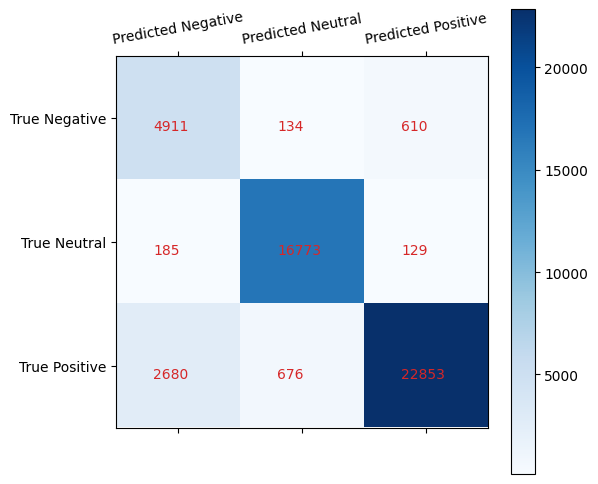

In [ ]:
# Test etme sonuçları kontrol etme
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

#cv_scores = cross_val_score(LogisticRegression, X_train, y_train, cv=50)
#print("CV average score: %.2f" % cv_scores.mean())


result = final_pipeline.predict(X_test)
cr = classification_report(y_test, result)
print(cr)


print('Train Accuracy : %.3f'%final_pipeline.score(X_train, y_train))
print('Test Accuracy : %.3f'%final_pipeline.score(X_test, y_test), "\n")



y_pred = final_pipeline.predict(X_test)
print(precision_score(y_test, y_pred ,average='macro') , ": is the precision score")
print(recall_score(y_test, y_pred,average='macro'), ": is the recall score")
print(f1_score(y_test, y_pred ,average='macro'), ": is the f1 score \n")

plot_confusion_matrix(y_test, final_pipeline.predict(X_test))

In [ ]:
text_list = ["Bu film çok güzel çok beğendim.", "Çok kötü bir film olmuş kesinlikle izlenmemesi gerekiyor.", "kırmızı araba", "Kesinlikle İzleyin",
             "kesinlikle izlemeyin", "Binovist Çok Güzel Bir Şirket", "Hayat Çok Sıkıcı", "İnsanların 2 ayağı vardır", "Rubic Cube", "Kırmızı", "Binovist", "Sen Çok Şişkosun"]

max_length = max(len(sentence) for sentence in text_list) +5

for i, sentence in enumerate([sentence + ' ' for sentence in text_list]):

  prediction=final_pipeline.predict([text_list[i]])
  proportion=final_pipeline.predict_proba([text_list[i]])

  #print(prediction[0])

  if prediction[0] == 0:
      sentiment = f"{proportion[0][0] * 100:.2f}% Negative"
  elif prediction[0] == 1:
      sentiment = f"{proportion[0][1] * 100:.2f}% Neutral"
  else:
      sentiment = f"{proportion[0][2] * 100:.2f}% Positive"

  print(f"{sentence.ljust(max_length, '-')}> {sentiment}")

Bu film çok güzel çok beğendim. ------------------------------> 97.85% Positive
Çok kötü bir film olmuş kesinlikle izlenmemesi gerekiyor. ----> 99.75% Negative
kırmızı araba ------------------------------------------------> 53.54% Neutral
Kesinlikle İzleyin -------------------------------------------> 83.88% Positive
kesinlikle izlemeyin -----------------------------------------> 99.94% Negative
Binovist Çok Güzel Bir Şirket --------------------------------> 66.36% Positive
Hayat Çok Sıkıcı ---------------------------------------------> 90.86% Negative
İnsanların 2 ayağı vardır ------------------------------------> 99.63% Neutral
Rubic Cube ---------------------------------------------------> 59.16% Neutral
Kırmızı ------------------------------------------------------> 86.54% Neutral
Binovist -----------------------------------------------------> 75.43% Neutral
Sen Çok Şişkosun ---------------------------------------------> 95.90% Negative


In [ ]:
#SentiTurkNet ile yapay zekasız duygu analizi projesi geliştirme

In [ ]:
#Oluşturulan Verilerin Görsellik İçin Ünlü insanların yaptıkları twiterlardan duygu analizi tablosu oluşturma

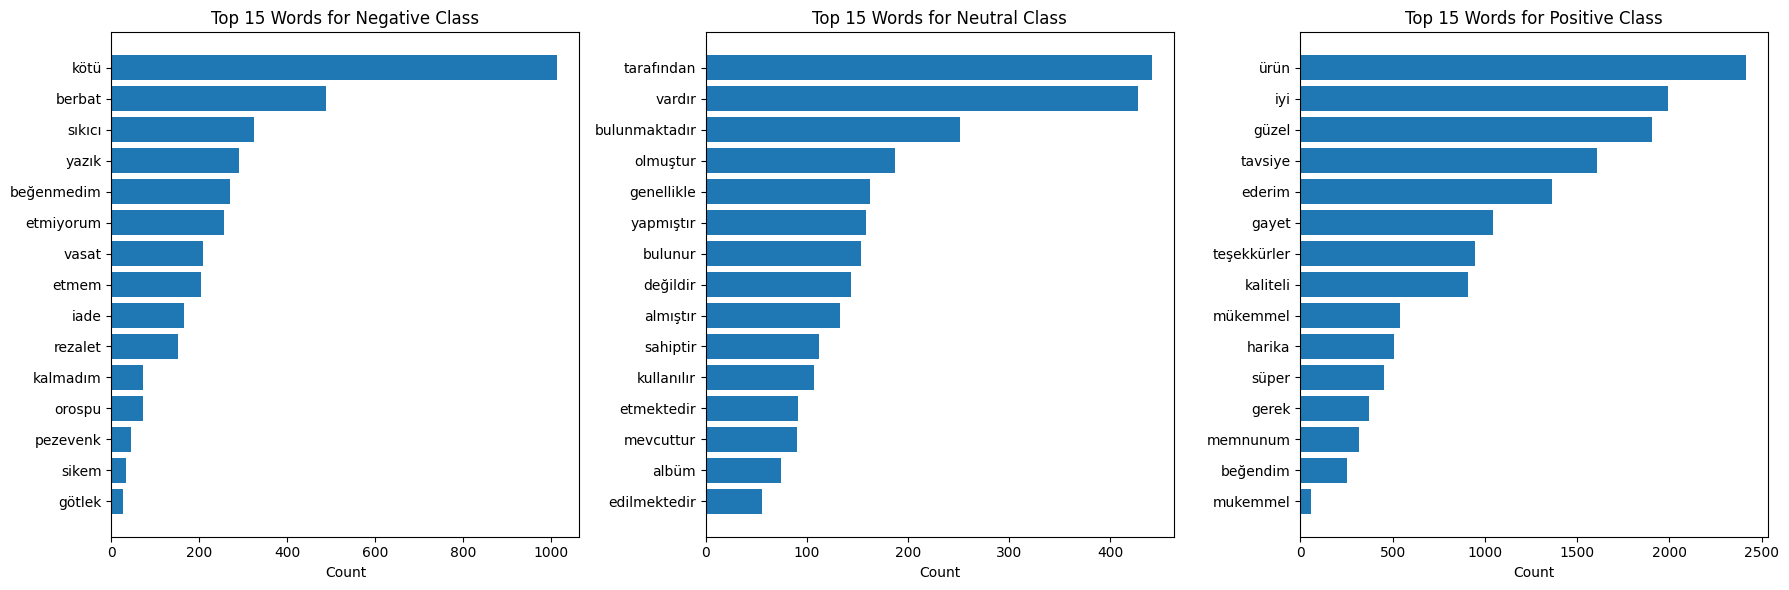

In [ ]:
# Extracting the Logistic Regression model from the pipeline
logreg = final_pipeline.named_steps['clf']
coefficients = logreg.coef_

# Map the coefficients to their respective classes
classes = ['Negative', 'Neutral', 'Positive']
coefficients_dict = {cls: coefficients[i] for i, cls in enumerate(classes)}

# Visualization
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, cls in enumerate(classes):
    coef = coefficients_dict[cls]
    top_15_indices = np.argsort(coef)[-15:]  # Top 15 words
    top_15_words = [feature_names[i] for i in top_15_indices]
    top_15_weights = coef[top_15_indices]

    top_15_counts = [word_freq[word] for word in top_15_words]

    # Sort from highest to lowest
    sorted_indices = np.argsort(top_15_counts)[::-1]
    top_15_words = [top_15_words[i] for i in sorted_indices]
    top_15_counts = [top_15_counts[i] for i in sorted_indices]

    axs[i].barh(top_15_words, top_15_counts, align='center')
    axs[i].set_xlabel('Count')
    axs[i].set_title(f'Top 15 Words for {cls} Class')
    axs[i].invert_yaxis()  # Invert y-axis for top-to-bottom reading

plt.tight_layout()
plt.show()

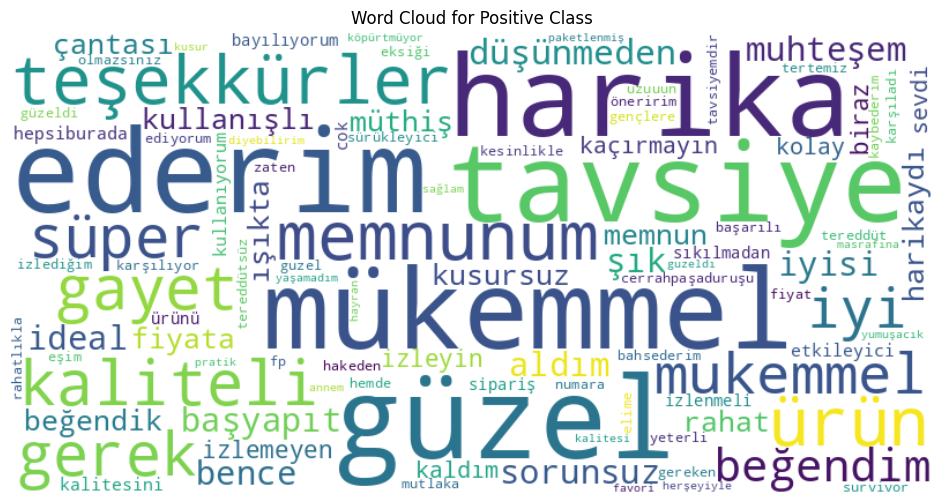

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract the Logistic Regression model from the pipeline
logreg = final_pipeline.named_steps['clf']
coefficients = logreg.coef_

# Map the coefficients to their respective classes
classes = ['Negative', 'Neutral', 'Positive']
positive_coefficients = coefficients[classes.index('Positive')]

# Generate the word cloud for the Positive class
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,  # Maximum number of words to display
    max_font_size=100,  # Maximum font size
    min_font_size=10,   # Minimum font size
    collocations=False, # Prevents the same words from appearing together
    normalize_plurals=True # Normalize plurals to their singular forms
).generate_from_frequencies(dict(zip(feature_names, positive_coefficients)))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Class')
plt.show()
